In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def morph_sawtooth_triangle(t, morph):
    """
    Create a piecewise-linear waveform where the time p at which x==+1
    is determined by morph (p = morph). We do NOT blend saw and triangle
    amplitudes; instead we change the slopes so the peak time equals morph.

    For numerical stability, clamp p into (eps, 1-eps).

    Behavior:
      - t in [0, p]: linear rise from -1 to +1
      - t in (p, 1]: linear fall from +1 to -1

    morph in [0,1] maps directly to p (peak time).
    """
    t_norm = t - np.floor(t)

    # peak time equals morph, clamp to avoid division by zero
    eps = 1e-6
    p = np.clip(morph, eps, 1.0 - eps)

    # Rising segment: -1 -> +1 over [0, p]
    rise = -1 + (2.0 / p) * t_norm
    # Falling segment: +1 -> -1 over (p,1]
    fall = 1 + (-2.0 / (1.0 - p)) * (t_norm - p)

    triangle_like = np.where(t_norm <= p, rise, fall)
    return triangle_like



In [3]:
def morph_triangle_sin(t, morph, freq=1.0):
    """
    Crossfade between a triangle wave (morph=0 -> 100%) and a sine wave (morph=1 -> 100%).

    Inputs:
      - t: time (array-like), normalized so 1 period = 1. Can be >1 for multiple periods.
      - morph: 0..1, 0 => triangle only, 1 => sine only
      - freq: frequency in cycles per unit t (default 1)

    Output: waveform in range [-1, 1]
    """
    # normalize time to phase [0,1)
    t_norm = (t * freq) - np.floor(t * freq)

    # triangle: -1 at t=0, +1 at t=0.5, -1 at t=1
    tri = np.where(t_norm <= 0.5, -1 + 4 * t_norm, 3 - 4 * t_norm)

    # sine: use -cos for phase alignment (sine-like)
    sine = - np.cos(2 * np.pi * t * freq)

    # linear crossfade: morph=0 -> tri, morph=1 -> sine
    morph = np.clip(morph, 0.0, 1.0)
    out = (1.0 - morph) * tri + morph * sine
    return out



In [4]:

def morph_sin_square(t, morph, freq=1.0, duty=0.5):
    """
    Crossfade between a -cos wave (named "sin" for API) and a square wave.

    Inputs:
      - t: time (array-like)
      - morph: 0..1 (0 => -cos only, 1 => square only)
      - freq: frequency in cycles per unit t
      - duty: duty cycle for square wave (0..1), default 0.5 (ignored now)

    Output: waveform in [-1,1]
    """
    t_norm = (t * freq) - np.floor(t * freq)
    # -cos wave
    sine_like = - np.cos(2 * np.pi * t * freq)

    # square wave: +1 for 0.25 <= phase < 0.75, else -1
    square = np.where((t_norm >= 0.25) & (t_norm < 0.75), 1.0, -1.0)

    morph = np.clip(morph, 0.0, 1.0)
    out = (1.0 - morph) * sine_like + morph * square
    return out


In [10]:

# 確認プロット
def plot_waveform(func):
    fs = 1000
    vals = [0.0, 0.25, 0.5, 0.75, 1.0]
    
    if False:
        t = np.linspace(0, 2, fs * 2)
        plt.figure(figsize=(12, 8))
        for i, m in enumerate(vals):
            y = func(t, m)
            plt.subplot(len(vals), 1, i+1)
            plt.plot(t, y, linewidth=1.2)
            plt.title(f'morph_sin_square morph={m}')
            plt.ylim(-1.2, 1.2)
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    # 1周期重ね表示
    t1 = np.linspace(0, 1, fs)
    plt.figure(figsize=(10, 6))
    for m in vals:
        plt.plot(t1, func(t1, m), label=f'm={m}')
    plt.legend()
    plt.title('Sin(-cos) <-> Square crossfade (single period)')
    plt.grid(True)
    plt.show()

    if False:
        # サンプル出力
        for m in [0.0, 0.5, 1.0]:
            t_check = np.array([0.0, 0.25, 0.5, 0.75])
            print(f'morph={m} ->', func(t_check, m))


In [ ]:
import numpy as np

def _phase_shift_for_mode(mode: str) -> float:
    """
    mode:
      'sin'      -> sin(θ)
      'cos'      -> cos(θ) = sin(θ + π/2)
      'sin_inv'  -> -sin(θ)
      'cos_inv'  -> -cos(θ)
    """
    mode = mode.lower()
    if mode == "sin":
        return 0.0
    if mode == "cos":
        return np.pi / 2.0
    if mode == "sin_inv":
        return 0.0
    if mode == "cos_inv":
        return np.pi / 2.0
    raise ValueError("mode must be one of: 'sin', 'cos', 'sin_inv', 'cos_inv'")


def morph_rect_to_sine_phase(theta, morph=0.5, mode="sin", bias=0.0):
    """
    角が立った矩形っぽさ -> 正弦（sin/cos）へ“丸めて”連続遷移する波形。
    アナログシンセの 'shape' ノブの感覚で使えるようにスケール調整済み。
    
    Parameters
    ----------
    theta : array_like
        位相 [rad]。2πで一周。np.linspaceなどで作る。
    morph : float in [0, 1]
        0   = ほぼ矩形（角が鋭い）
        1   = ほぼ正弦（丸い）
        推奨: ノブをそのままバインド
    mode : str
        'sin', 'cos', 'sin_inv', 'cos_inv'
    bias : float in [-1, 1]
        デューティ感のバイアス。0で対称、正で上側広め（しきい値を下げる）、
        負で下側広め。PWMっぽい味付け用。使わないなら0。
    
    Returns
    -------
    y : ndarray
        [-1, 1] に正規化された波形
    """
    # 位相モード（sin/cos/反転）
    phi = _phase_shift_for_mode(mode)
    sign_flip = -1.0 if "inv" in mode.lower() else 1.0

    # “角の丸さ”を決めるゲインgを、morph∈[0,1] から滑らかに作る
    # morph=0 -> gが大 -> ほぼ矩形、morph=1 -> gが小 -> ほぼ正弦
    # ロジット風カーブで手元感を良くする
    eps = 1e-6
    # 最大/最小ゲイン（耳で気持ちいいレンジ）
    g_max = 20.0
    g_min = 1e-3
    # morphを非線形に（中域で気持ちよく動くように）
    m = np.clip(morph, 0.0, 1.0)
    m_nl = m**0.6
    # gは (1-m) に応じて変化
    g = g_min + (1.0 - m_nl) * (g_max - g_min)

    # バイアス（デューティ味）: sin(θ+φ) にオフセットを足して閾値を揺らす
    s = np.sin(theta + phi) - np.clip(bias, -1.0, 1.0) * 0.6

    # 角丸スクエア～サイン：tanhでスムーズにサチュレーション
    # 正規化で振幅を常に±1近傍に維持
    y = np.tanh(g * s)
    y /= np.tanh(g + eps)

    return sign_flip * y


def morph_rect_to_sine_time(n_samples=48000, freq=220.0, sr=48000,
                            morph=0.5, mode="sin", bias=0.0, phase0=0.0):
    """
    サンプル数・周波数指定で波形生成（オシレータ用の便利関数）
    """
    t = np.arange(n_samples) / float(sr)
    theta = 2.0 * np.pi * freq * t + phase0
    return morph_rect_to_sine_phase(theta, morph=morph, mode=mode, bias=bias)


In [15]:
funcs = [morph_triangle_sin,
         morph_sawtooth_triangle,
         morph_sin_square
]

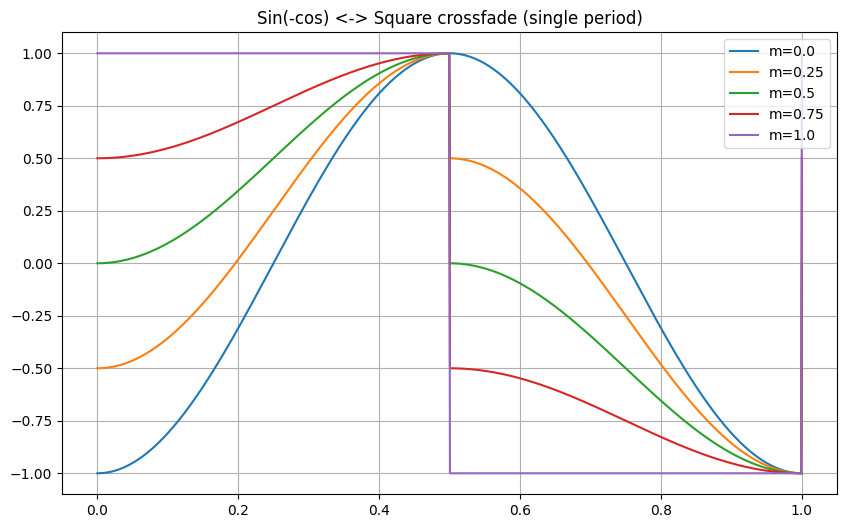

In [18]:

plot_waveform(funcs[-1])